# HW 11 Assignment 2: Clustering Business
Nurvirta Monarizqa (nm2773)

In [1]:
# import necessary packages
import pandas as pd
import numpy as np
import urllib
import os
from zipfile import ZipFile
import json
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from descartes import PolygonPatch
from matplotlib import cm
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster
import matplotlib.patches as mpatches
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 1. Get and prep data

In [2]:
# store environment variable PUIDATA to variable PUIDATA
PUIDATA = os.getenv('PUIDATA')

### a. NYC business data

I downloaded all the data and put them in a folder inside 'PUIdata' folder called 'zbp'. In the cell below, I:

- opened every single zipfiles,
- read the txt data as `DataFrame`,
- created column to store the year called `YEAR`
- selected necessary columns (`ZIP`,`YEAR`,`EST`)
- concatenated each year's DataFrame to a single DataFrame called df

In [3]:
years = range(1995,2015)
df = pd.DataFrame()

for year in years:
    abbr_year = str(year)[2:4]
    fname = 'zbp' + abbr_year + 'totals.zip'
    
    # data stored in PUIDATA folder 'zbp'
    fullname = PUIDATA + '/zbp/' + fname
    zf = ZipFile(fullname)
    
    # open and read file
    df_that_year = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    
    # uppercase, to make the columns in a uniform case
    df_that_year.columns = [item.upper() for item in df_that_year.columns] 
    df_that_year['YEAR'] = year
    
    # subset necessary columns
    df_sliced = df_that_year.loc[:,['ZIP','EST','YEAR']]
    
    # concat (merge) this year's dataframe to main dataframe
    df = pd.concat([df, df_sliced], axis=0)

In [4]:
df.head()

,ZIP,EST,YEAR
0,501,2,1995
1,1000,4,1995
2,1001,439,1995
3,1002,467,1995
4,1003,10,1995


### b. NYC zipcodes and polygon
I opened the NYC geojson with `json` package. Then, I collected the zipcodes and polygons in a `DataFrame` called `nyc_shape`

In [5]:
with open(PUIDATA + '/zbp/nyc-zip-code-tabulation-areas-polygons.geojson') as f:
    nyc_geojson = pd.DataFrame(json.load(f))

In [6]:
zipcodes = []
polygons = []
for i in range(len(nyc_geojson)):
    zipcode = nyc_geojson.ix[i]['features']['properties']['postalCode']
    poly = nyc_geojson.ix[i]['features']['geometry']
    zipcodes.append(int(zipcode))
    polygons.append(poly)
nyc_shape = pd.DataFrame({'geometry': polygons, 'ZIP':zipcodes})

In [7]:
nyc_shape.head()

,ZIP,geometry
0,11372,"{u'type': u'Polygon', u'coordinates': [[[-73.8..."
1,11004,"{u'type': u'Polygon', u'coordinates': [[[-73.7..."
2,11040,"{u'type': u'Polygon', u'coordinates': [[[-73.7..."
3,11426,"{u'type': u'Polygon', u'coordinates': [[[-73.7..."
4,11365,"{u'type': u'Polygon', u'coordinates': [[[-73.8..."


### c. Merge NYC business data and NYC shape data
To prepare the data for clustering, we have to merge the business data and NYC shape data. Then, create a table with zipcodes as index, time (year) as column. Lastly, we have to standardized the data.

In [8]:
# put ZIP as index, so we can easily call the index 
# to subset the selected zipcodes (NYC zipcodes)
df.index = df.ZIP

In [9]:
# subset all df with 'zipcodes' (NYC zipcodes) as its index,
# remove all rows that contains no info
df_NY = df.ix[zipcodes].dropna(how='any')

# convert ZIP and YEAR as int
df_NY['ZIP'] = df_NY['ZIP'].astype(int)
df_NY['YEAR'] = df_NY['YEAR'].astype(int)

In [10]:
# call pivot_table function in pandas to create DataFrame with 
# ZIP as index, YEAR as columns, and EST as values
df_NY_pivot = df_NY.pivot_table(index='ZIP', columns='YEAR', values='EST')
df_NY_pivot.head()

YEAR,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
ZIP,,,,,,,,,,,,,,,,,,,,
10001,7088.0,7075.0,7154.0,7254.0,7233.0,7317.0,7188.0,7141.0,7084.0,7370.0,7312.0,7415.0,7549.0,7472.0,7305.0,7241.0,7227.0,7235.0,7273.0,7369.0
10002,1819.0,1919.0,2049.0,2003.0,2085.0,2277.0,2543.0,2269.0,2402.0,2551.0,2682.0,2686.0,2685.0,2691.0,2775.0,2872.0,2912.0,2954.0,2988.0,2972.0
10003,3377.0,3417.0,3535.0,3649.0,3659.0,3683.0,3602.0,3616.0,3704.0,3776.0,3867.0,3909.0,4049.0,4071.0,4099.0,4113.0,4159.0,4214.0,4277.0,4333.0
10004,1124.0,1133.0,1173.0,1176.0,1233.0,1294.0,1247.0,1253.0,1252.0,1283.0,1260.0,1311.0,1370.0,1376.0,1379.0,1398.0,1404.0,1442.0,1479.0,1554.0
10005,1109.0,1216.0,1227.0,1270.0,1242.0,1287.0,1249.0,1244.0,1200.0,1226.0,1214.0,1259.0,1273.0,1291.0,1274.0,1266.0,1301.0,1273.0,1296.0,1321.0


In [12]:
df_NY_pivot.shape

(244, 20)

Now we have to standardize all values. For every row, I calculated the mean and standard deviation, then for every value, I substract the value with mean of its respective row, divided by standard deviation of its respective row.

In [13]:
# standardize values, started with dropping NaN values
df_NY_standardized = df_NY_pivot.dropna(how='any').copy()
for row in df_NY_standardized.index:
    row_values = df_NY_pivot.ix[row]
    row_mean = row_values.mean()
    row_std = row_values.std()
    df_NY_standardized.ix[row] = (row_values - row_mean)/row_std

In [14]:
df_NY_standardized.head()

YEAR,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
ZIP,,,,,,,,,,,,,,,,,,,,
10001,-1.381360,-1.482758,-0.866567,-0.086579,-0.250376,0.404814,-0.601371,-0.967966,-1.412559,0.818208,0.365815,1.169203,2.214387,1.613796,0.311215,-0.187977,-0.297176,-0.234777,0.061619,0.810408
10002,-1.814430,-1.550589,-1.207597,-1.328964,-1.112615,-0.606041,0.095774,-0.627148,-0.276241,0.116881,0.462512,0.473066,0.470427,0.486258,0.707884,0.963809,1.069345,1.180158,1.269863,1.227649
10003,-1.636189,-1.499399,-1.095866,-0.706012,-0.671814,-0.589740,-0.866741,-0.818864,-0.517924,-0.271701,0.039498,0.183129,0.661897,0.737132,0.832885,0.880762,1.038072,1.226159,1.441604,1.633112
10004,-1.573020,-1.495680,-1.151944,-1.126164,-0.636341,-0.112144,-0.516033,-0.464473,-0.473066,-0.206671,-0.404319,0.033944,0.540954,0.592514,0.618294,0.781569,0.833129,1.159678,1.477633,2.122138
10005,-3.070763,-0.771451,-0.535073,0.388949,-0.212740,0.754260,-0.062318,-0.169762,-1.115274,-0.556562,-0.814429,0.152571,0.453416,0.840216,0.474905,0.302993,1.055105,0.453416,0.947660,1.484883


## 2. Cluster the number of establishments time series with K-Means
Now that we have standardized values, we have to cluster time series for all zipcodes. To determine number of cluster, I used elbow method below. Note that this piece of code is from ADS class lab, so you might find another student using the exact same code.

In [15]:
def elbow(data, K):
    '''This function is to calculate average within-cluster
    sum of squares, and plot the "elbow"
    data: dataframe of features,
    K: list of selected number of cluster'''
    
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    centroids = [k.cluster_centers_ for k in KM]
    
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    globals()['dist'] = [np.min(D, axis=1) for D in D_k]
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()

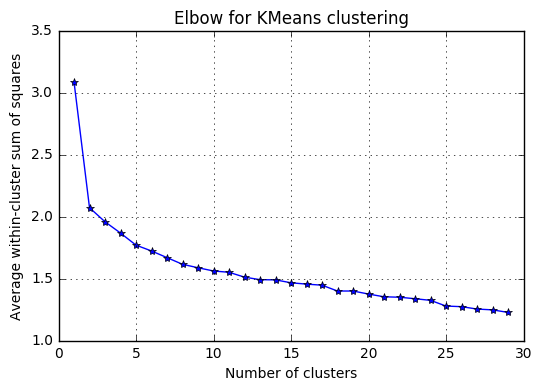

In [16]:
elbow(df_NY_standardized, range(1,30))

**Figure 1: Elbow for KMeans clustering**

As we can see here, the plot drop significantly before it goes down steadily. The "elbow" happened when the number of clusters equals 2, but, since the Professor suggest us to pick a few, more than a couple, I chose **4** as number of cluster (next "elbow").

In [17]:
# implement k-means
km = KMeans(4).fit(df_NY_standardized)

In [18]:
# store the result in 'kmeans' column
df_NY_standardized['kmeans'] = km.labels_

##  3. Plot the cluster centers

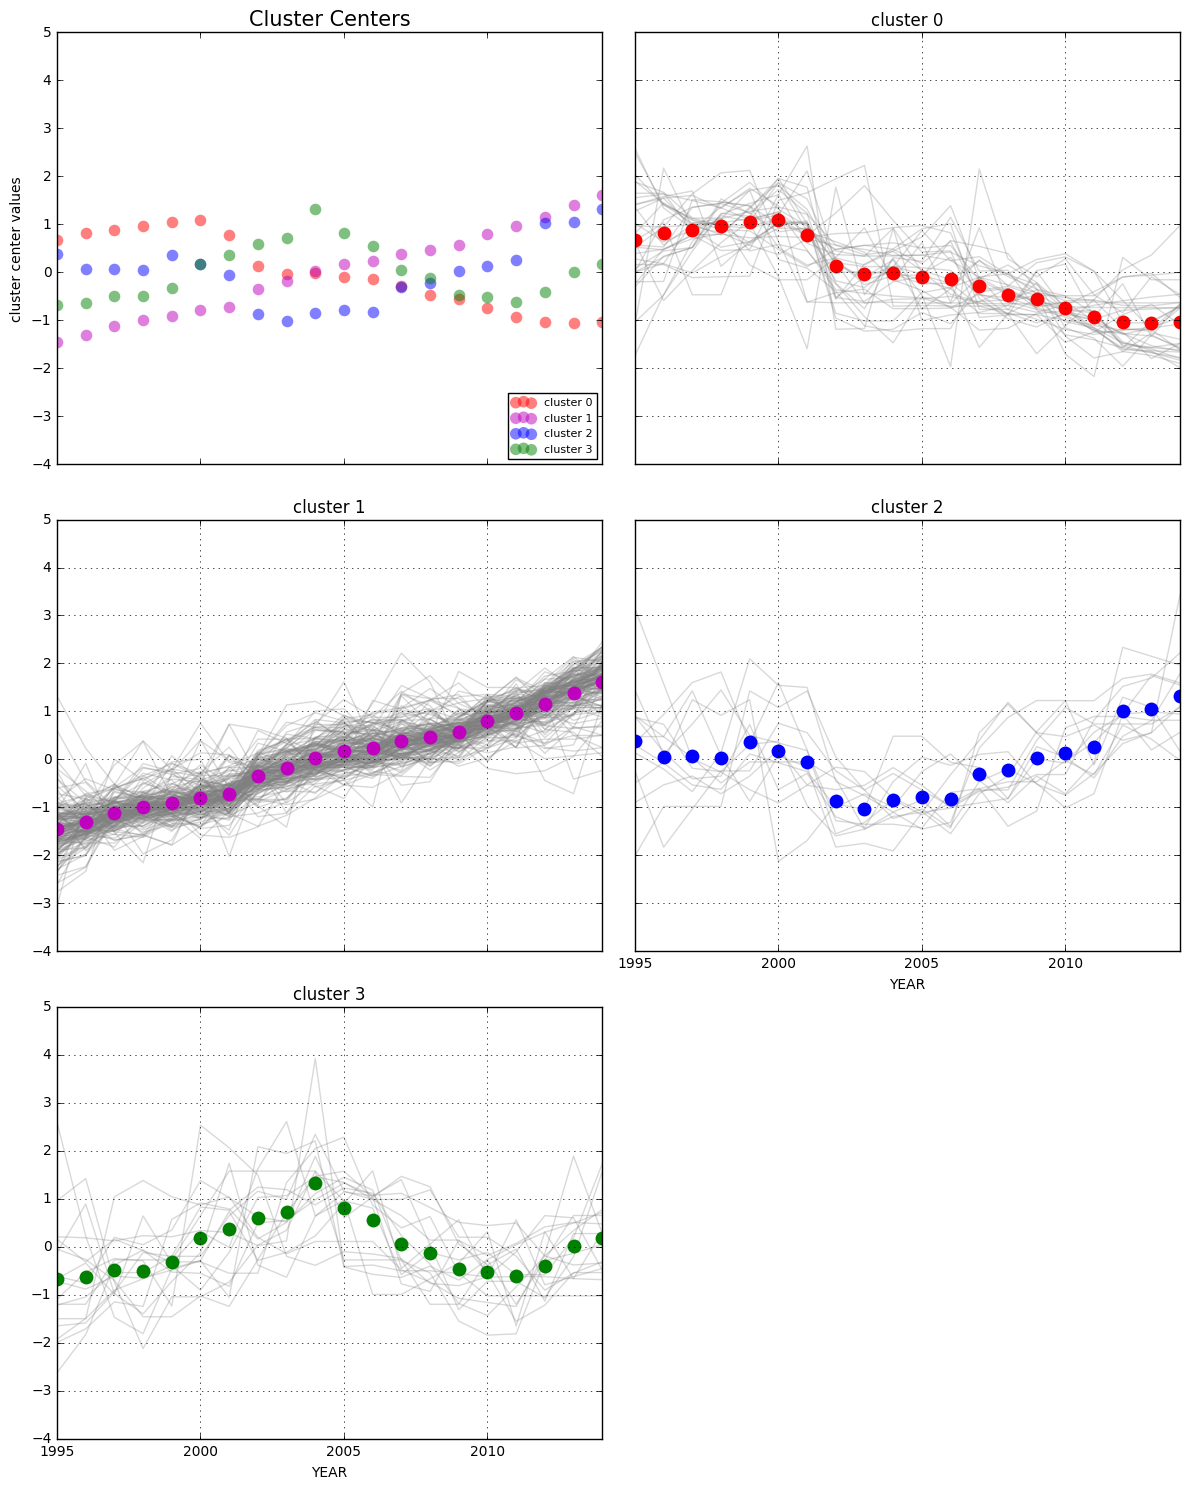

In [48]:
fig = plt.figure(figsize=(12,15))
ax1 = fig.add_subplot(3,2,1)
c = ['r','m','b','g']

# first subplot: all cluster centers
for i in range(4):
    ax1.scatter(years,km.cluster_centers_[i], c=c[i], 
                lw=0, alpha=0.5, s=70, label='cluster ' + str(i))
ax1.legend(loc='lower right', fontsize=8)
ax1.set_title('Cluster Centers', fontsize=15)
ax1.set_xlabel('year')
ax1.set_ylabel('cluster center values')
ax1.set_ylim(-3,4)

# other subplots: plot the timeseries and its cluster centers
for subplot_number in [2, 3, 4, 5]:
    ax = fig.add_subplot(3, 2, subplot_number, sharex=ax1, sharey=ax1)
    features = df_NY_standardized.iloc[:, 0:20]
    cluster = subplot_number - 2
    features[df_NY_standardized['kmeans'] == cluster].T\
        .plot(legend=False, alpha=0.3, c='grey', ax=ax, zorder=1)
    ax.scatter(years, km.cluster_centers_[cluster], c=c[cluster], zorder=2,
               lw=0, s=100)
    ax.set_title('cluster '+ str(cluster))
    ax.grid()
plt.tight_layout()

**Figure 2: Plot all cluster centers with their respective time series**

We can see here all clusters have different trends.
- Cluster 0: decreasing trend
- cluster 1: increasing trend
- cluster 3: decreasing in early 2000 before slowly increasing
- cluster 4: has a peak in mid 2000

## 4. Use another clustering algorithm

I used hierarchical clustering here.

In [20]:
# select all features' data, store in a variable X
X = df_NY_standardized.iloc[:, 0:20]

In [21]:
# linkage all observations
links = linkage(X, 'ward')

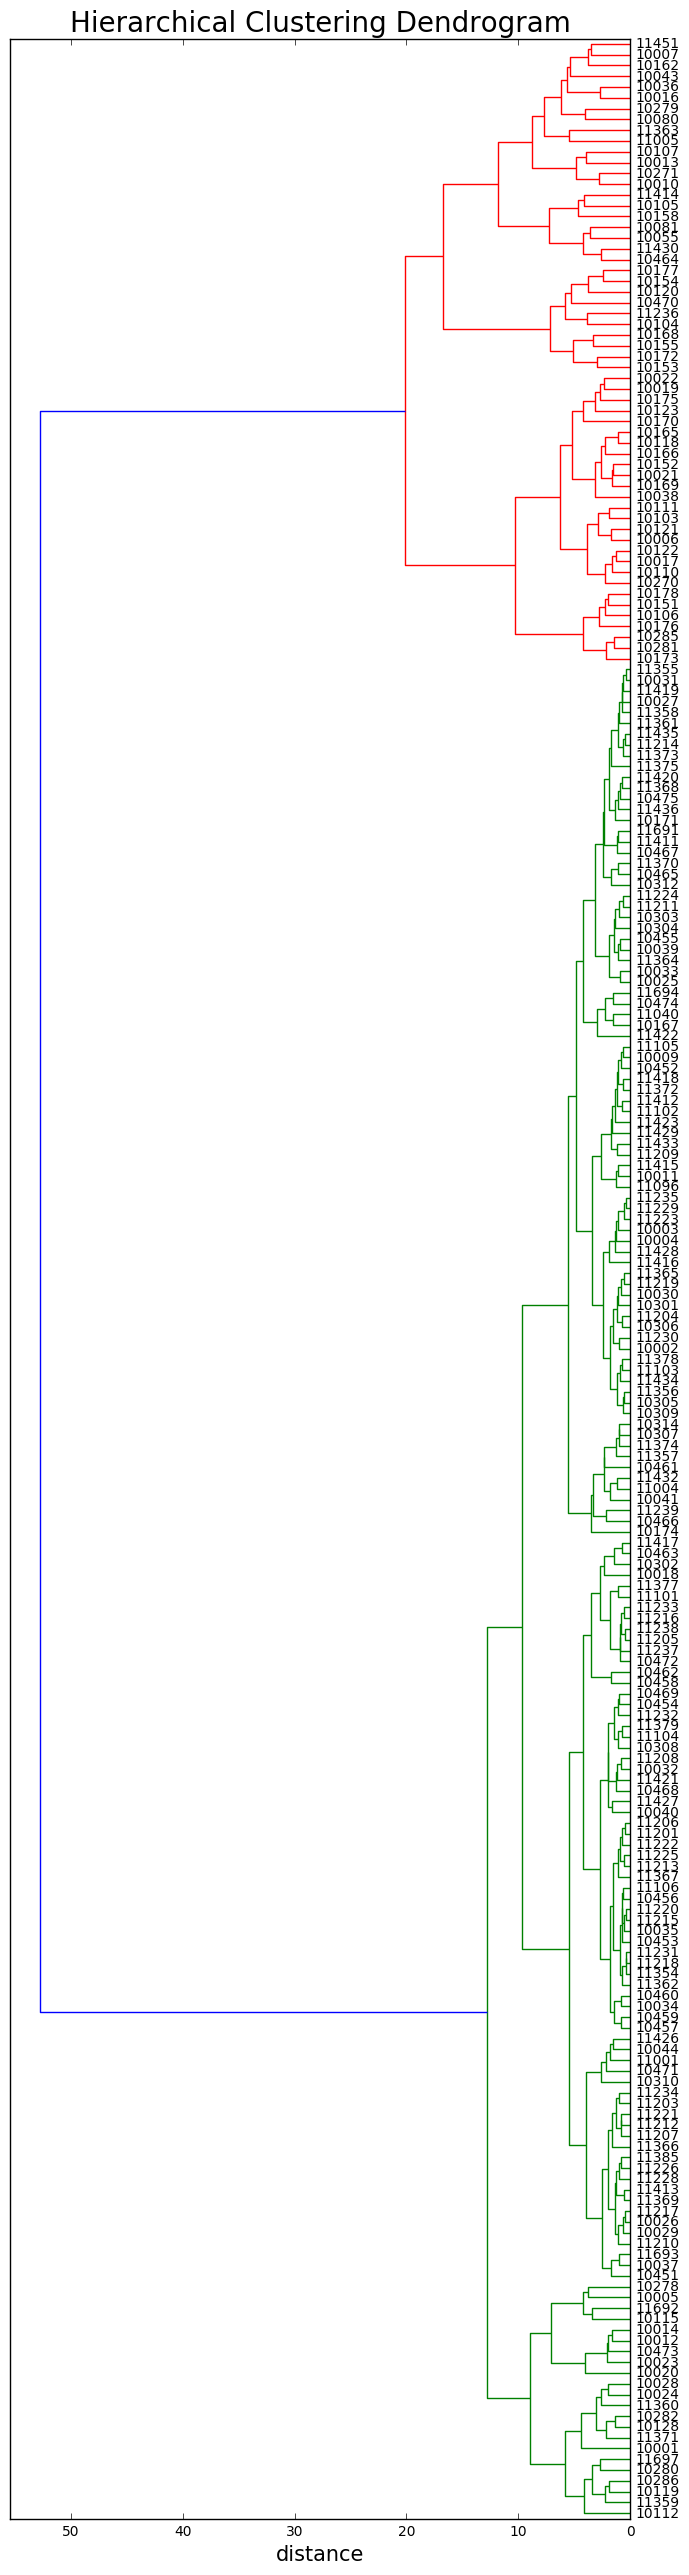

In [22]:
# plot the dendrogram
plt.figure(figsize=(8, 32))
plt.title('Hierarchical Clustering Dendrogram', fontsize=20)
plt.xlabel('distance', fontsize=15)
dendrogram(links, leaf_font_size=10, orientation='left', labels=X.index)
plt.show()

** Figure 3: Hierarchical Clustering Dendrogram**

In figure 3, we can see that there are 2 main clusters based on the linkage (green and red)

In [23]:
# pick only 4 clusters from hierarchical clustering
# store the labels into 'hierarchical' column in 'df_NY_standardized'

k = 4
df_NY_standardized['hierarchical'] = fcluster(links, k, criterion='maxclust')

## 5. Overlay data on a NYC map

In [24]:
# previously we have nyc_shape
nyc_shape.head()

,ZIP,geometry
0,11372,"{u'type': u'Polygon', u'coordinates': [[[-73.8..."
1,11004,"{u'type': u'Polygon', u'coordinates': [[[-73.7..."
2,11040,"{u'type': u'Polygon', u'coordinates': [[[-73.7..."
3,11426,"{u'type': u'Polygon', u'coordinates': [[[-73.7..."
4,11365,"{u'type': u'Polygon', u'coordinates': [[[-73.8..."


Now, add columns within `nyc_shape`, to store both kmeans and hierarchical labels

In [25]:
print "Unique k-means cluster:", df_NY_standardized['kmeans'].unique()
print "Unique hierarchical cluster:", df_NY_standardized['hierarchical'].unique()

Unique k-means cluster: [1 0 3 2]
Unique hierarchical cluster: [1 2 4 3]


we can see here, k-means cluster starts from 0, where hierarchical starts from 1, thus, we have to replace all NaN values with -1 and 0 respectively for k-means and hierarchical

In [26]:
# kmeans
df_labels = pd.DataFrame(df_NY_standardized['kmeans']).reset_index()
nyc_shape = pd.merge(nyc_shape,df_labels, how='left', on='ZIP')
nyc_shape.fillna(-1, inplace=True) # because first cluster start from 0

In [27]:
# hierarchical
df_labels = pd.DataFrame(df_NY_standardized['hierarchical']).reset_index()
nyc_shape = pd.merge(nyc_shape,df_labels, how='left', on='ZIP')
nyc_shape.fillna(0, inplace=True) # because first cluster start from 1

In [28]:
nyc_shape.tail()

,ZIP,geometry,kmeans,hierarchical
257,10065,"{u'type': u'Polygon', u'coordinates': [[[-73.9...",-1.0,0.0
258,10075,"{u'type': u'Polygon', u'coordinates': [[[-73.9...",-1.0,0.0
259,10069,"{u'type': u'Polygon', u'coordinates': [[[-73.9...",-1.0,0.0
260,10281,"{u'type': u'Polygon', u'coordinates': [[[-74.0...",0.0,2.0
261,10282,"{u'type': u'Polygon', u'coordinates': [[[-74.0...",1.0,1.0


In [29]:
def plotNY(column_cluster, n_cluster, desired_axis):
    ''' This function is to plot polygons of NYC:
    column_cluster: choose between kmeans or hierarchical,
    n_cluster: number of cluster,
    desired_axis: selected ax'''
    
    def getColorIndex(column_cluster, iter_number):
        '''This function is to get color index from cmap'''
        if (column_cluster == 'hierarchical') | (column_cluster == 'hierarchical2'):
            color_index = int(nyc_shape[column_cluster][iter_number])
        else:
            color_index = int(nyc_shape[column_cluster][iter_number]+1)
        return color_index
    
    ax = desired_axis
    colors = np.linspace(0, 1, n_cluster+1)
    cmap = cm.get_cmap('Blues')
    for i in range(len(nyc_shape)):
        poly = nyc_shape['geometry'][i]
        color_index = getColorIndex(column_cluster, i)
        color = cmap(colors[color_index])
        ax.add_patch(PolygonPatch(poly, fc=color, ec='k', zorder=2))
    ax.axis('scaled')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(column_cluster + ' Clustering', fontsize=20)
    
    handles=[]
    for t in range(1, n_cluster+1):
        color_index_handles = t
        color = cmap(colors[color_index_handles])
        if (column_cluster == 'hierarchical') | (column_cluster == 'hierarchical2'):
            label = 'cluster ' + str(t)
        else:
            label = 'cluster ' + str(t-1)
        locals()["patch_{}".format(t)] = mpatches.Patch(color=color, label=label)
        handles.append(locals()["patch_{}".format(t)])
    
    ax.legend(handles=handles, loc='upper left')

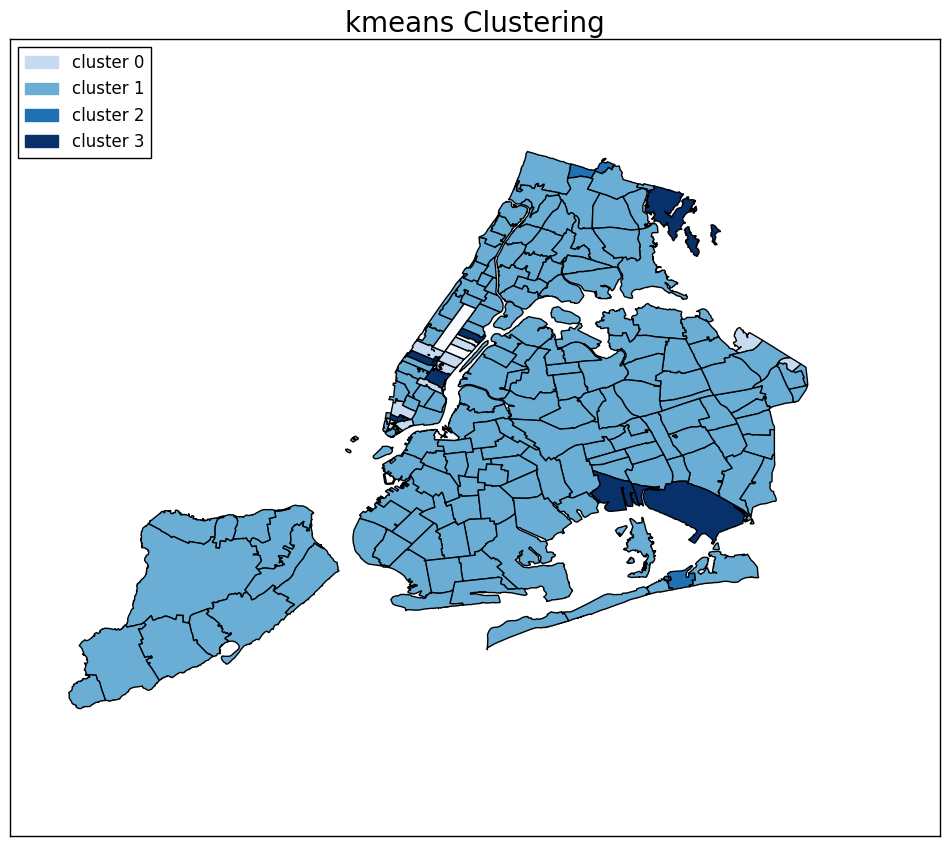

In [30]:
# plot kmeans cluster on NYC Map
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
plotNY('kmeans', 4, ax)

**Figure 4: KMeans on NYC Map**

If we see the trends in Figure 2, we know that cluster 0 (lightest one) has decreasing trend. Most of visible clusters 0 are around midtown Manhattan, downtown Mahattan,Upper East side, and some of them are in eastern part of Queens. Cluster 1 with increasing trend dominating the maps, while we barely see area within cluster 2. Clusters 3 are seen around JFK airport, some part of midtown, downtown, and northern part of The Bronx.

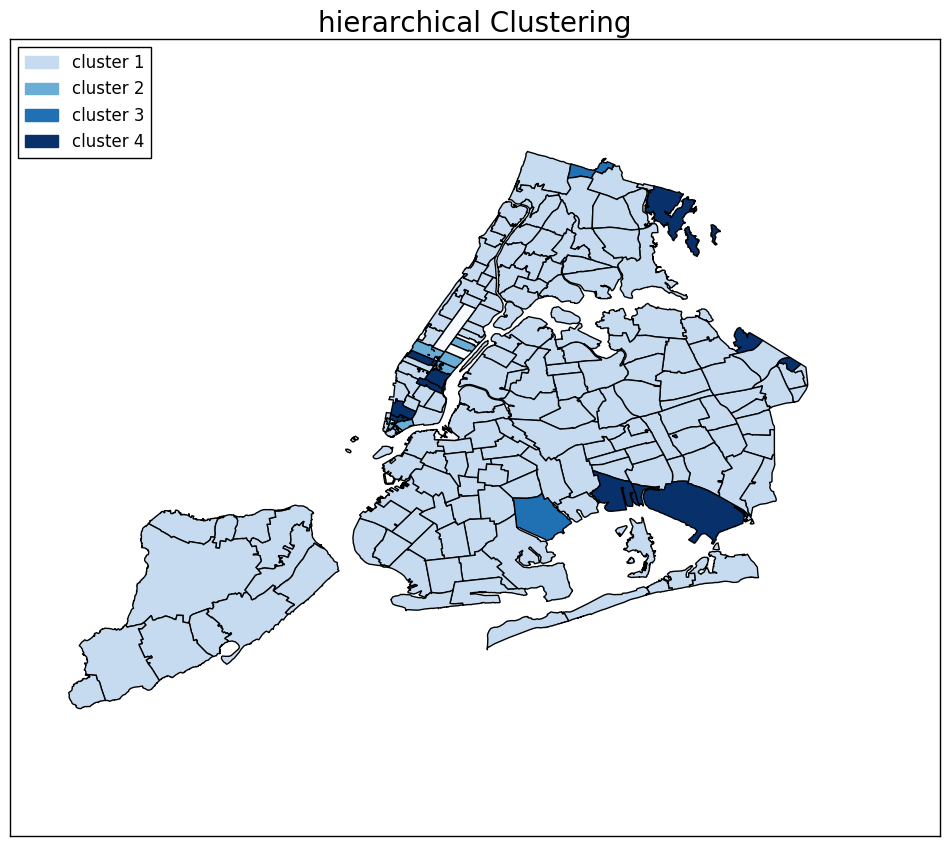

In [31]:
# plot hierarchical cluster on NYC Map
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
plotNY('hierarchical', 4, ax)

**Figure 5: Hierarchical Clustering on NYC Map**

We can see similar pattern with k-means here. Map is dominated by light blue color of cluster 1. Some cluster 2 spots are found in midtown Manhattan, few in downtown, as well as Upper east side. Cluster 4 can be found around JFK, midtown Manhattan, downtown Mahattan, northern Bronx, and some part in eastern Queens. Not so many cluster 3 areas are visible in figure 5. The most notable ones are Carnasie in Brooklyn, and Woodlawn Heights in Bronx.

In [49]:
nyc_shape[nyc_shape['hierarchical']==3]

,ZIP,geometry,kmeans,hierarchical,kmeans2,hierarchical2
39,10470,"{u'type': u'Polygon', u'coordinates': [[[-73.8...",2.0,3.0,0.0,2.0
161,11236,"{u'type': u'Polygon', u'coordinates': [[[-73.8...",1.0,3.0,0.0,2.0
197,10168,"{u'type': u'Polygon', u'coordinates': [[[-73.9...",2.0,3.0,0.0,2.0
210,10153,"{u'type': u'Polygon', u'coordinates': [[[-73.9...",2.0,3.0,1.0,2.0
215,10177,"{u'type': u'Polygon', u'coordinates': [[[-73.9...",2.0,3.0,0.0,2.0
216,10172,"{u'type': u'Polygon', u'coordinates': [[[-73.9...",2.0,3.0,1.0,2.0
218,10154,"{u'type': u'Polygon', u'coordinates': [[[-73.9...",2.0,3.0,0.0,2.0
221,10104,"{u'type': u'Polygon', u'coordinates': [[[-73.9...",2.0,3.0,1.0,2.0
235,10120,"{u'type': u'Polygon', u'coordinates': [[[-73.9...",2.0,3.0,0.0,2.0
237,10155,"{u'type': u'Polygon', u'coordinates': [[[-73.9...",2.0,3.0,0.0,2.0


## 6. Compare both Maps

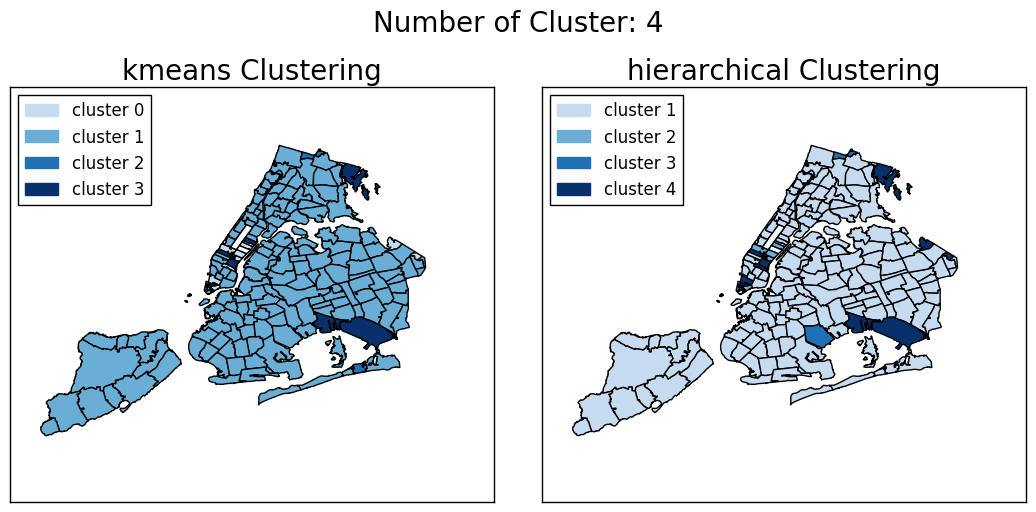

In [32]:
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(221)
plotNY('kmeans', 4, ax1)
ax2 = fig.add_subplot(222)
plotNY('hierarchical', 4, ax2)
plt.tight_layout(w_pad=0.2, h_pad=0.2, pad=5)
plt.suptitle('Number of Cluster: 4', fontsize=20)

**Picture 6: Comparison map of k-means and hierarchical clustering on NYC map**

At a glance, we can not really see differences on how they cluster the zipcodes between these 2 maps beside the colors. Some visible differences are in Carnasie (cluster 2 in K-Means and cluster 3 in hierarchical) and two zipcodes in the eastern part of Queens. In k-means, Carnasie has the same cluster as most of Brooklyn areas, while in hierarchical, it clustered differently from the rest of Brooklyn. For two areas in the eastern part of Queens, in k-means, both of them and JFK have different cluster but in hierarchical, they are clustered together.

Looking at these clusters only, we can draw an early conclusion that, the number of business establishment in Staten Island, Brookln, most part of Queens and Bronx are increasing while in Manhattan, it is more diverse.

### Compare with different number of cluster for both
Here we use number of cluster = 2

In [33]:
km2 = KMeans(2).fit(df_NY_standardized.iloc[:, 0:20])
df_NY_standardized['kmeans2'] = km2.labels_
df_NY_standardized['hierarchical2'] = fcluster(links, 2, criterion='maxclust')

In [34]:
# kmeans
df_labels = pd.DataFrame(df_NY_standardized['kmeans2']).reset_index()
nyc_shape = pd.merge(nyc_shape,df_labels, how='left', on='ZIP')
nyc_shape.fillna(-1, inplace=True) # because first cluster start from 0

# hierarchical
df_labels = pd.DataFrame(df_NY_standardized['hierarchical2']).reset_index()
nyc_shape = pd.merge(nyc_shape,df_labels, how='left', on='ZIP')
nyc_shape.fillna(0, inplace=True) # because first cluster start from 1

In [35]:
nyc_shape.tail()

,ZIP,geometry,kmeans,hierarchical,kmeans2,hierarchical2
257,10065,"{u'type': u'Polygon', u'coordinates': [[[-73.9...",-1.0,0.0,-1.0,0.0
258,10075,"{u'type': u'Polygon', u'coordinates': [[[-73.9...",-1.0,0.0,-1.0,0.0
259,10069,"{u'type': u'Polygon', u'coordinates': [[[-73.9...",-1.0,0.0,-1.0,0.0
260,10281,"{u'type': u'Polygon', u'coordinates': [[[-74.0...",0.0,2.0,1.0,2.0
261,10282,"{u'type': u'Polygon', u'coordinates': [[[-74.0...",1.0,1.0,0.0,1.0


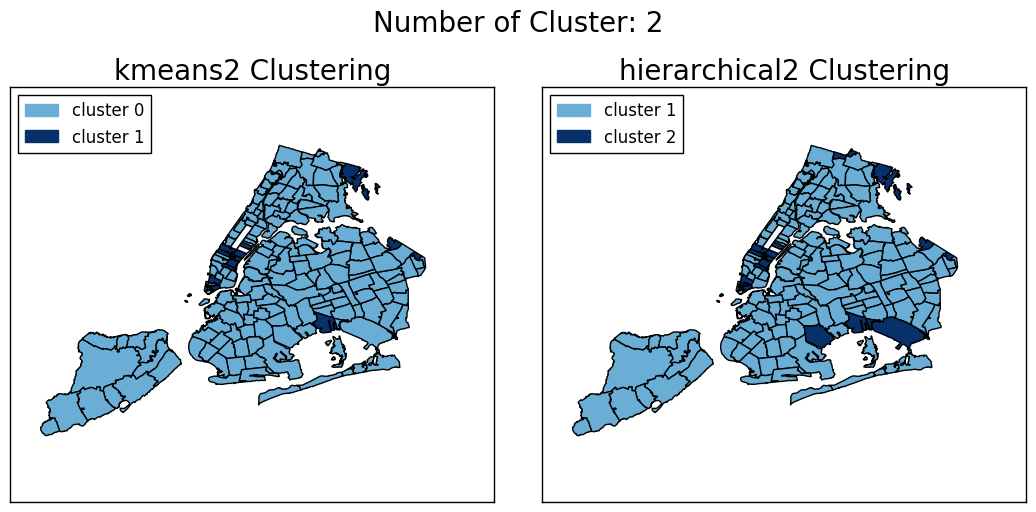

In [37]:
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(221)
plotNY('kmeans2', 2, ax1)
ax2 = fig.add_subplot(222)
plotNY('hierarchical2', 2, ax2)
plt.tight_layout(w_pad=0.2, h_pad=0.2, pad=5)
plt.suptitle('Number of Cluster: 2', fontsize=20)

**Picture 7: Comparison map of k-means and hierarchical clustering on NYC map with 2 clusters**

As both of the method suggested to have 2 clusters for each, I tried to apply both method to get 2 clusters. Turns out, noth of them show different result. The most notable differences are in JFK, Carnasie, eastern Queens and upper Bronx. In the code below, I plot the structure of k-means 2 clusters:

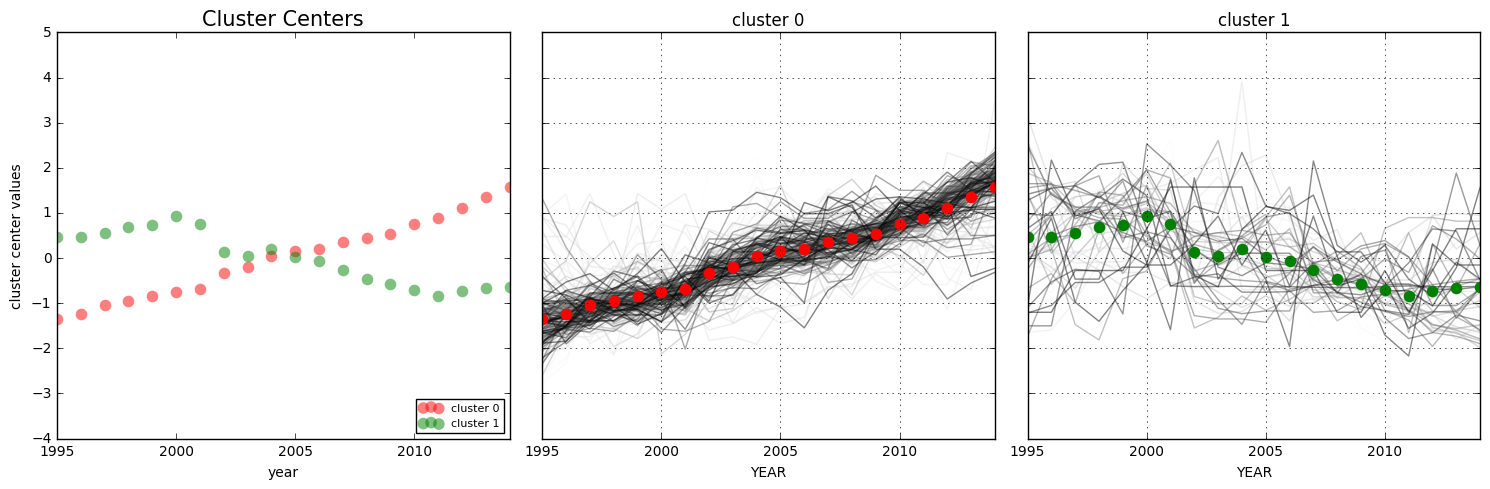

In [38]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1)
c = ['r','g']

# first subplot: all cluster centers
for i in range(2):
    ax1.scatter(years,km2.cluster_centers_[i], c=c[i], 
                lw=0, alpha=0.5, s=70, label='cluster ' + str(i))
ax1.legend(loc='lower right', fontsize=8)
ax1.set_title('Cluster Centers', fontsize=15)
ax1.set_xlabel('year')
ax1.set_ylabel('cluster center values')
ax1.set_ylim(-3,4)

for subplot_number in [2, 3]:
    ax = fig.add_subplot(1, 3, subplot_number, sharex=ax1, sharey=ax1)
    features = df_NY_standardized.iloc[:, 0:20]
    cluster = subplot_number - 2
    features[df_NY_standardized['kmeans2'] == cluster].T\
        .plot(legend=False, alpha=0.5, cmap='Greys', ax=ax, zorder=1)
    ax.scatter(years, km2.cluster_centers_[cluster], c=c[cluster], zorder=2,
               lw=0, s=70)
    ax.set_title('cluster '+ str(cluster))
    ax.grid()
plt.tight_layout()

**Picture 8: Structure of k-means 2 clusters on timeseries of NY business establishment**

There are 2 patterns, Cluster 0 for increasing trend and cluster 1 for decreasing trend. Now let's look at the hierarchical's structures:

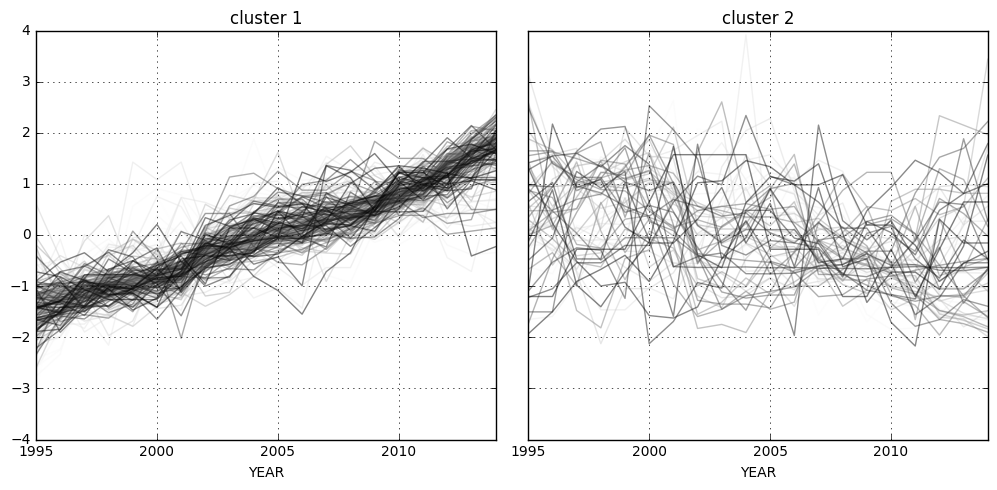

In [39]:
fig = plt.figure(figsize=(15,5))

for subplot_number in [1, 2]:
    ax = fig.add_subplot(1, 3, subplot_number, sharex=ax1, sharey=ax1)
    features = df_NY_standardized.iloc[:, 0:20]
    cluster = subplot_number
    features[df_NY_standardized['hierarchical2'] == cluster].T\
        .plot(legend=False, alpha=0.5, cmap='Greys', ax=ax, zorder=1)
    ax.set_title('cluster '+ str(cluster))
    ax.grid()
plt.tight_layout()

**Picture 9: Structure of hierarchical-2 clusters on timeseries of NY business establishment**

Apparently they have similar structures with k-means'. So, what kind of timeseries that both of them calculated differently?

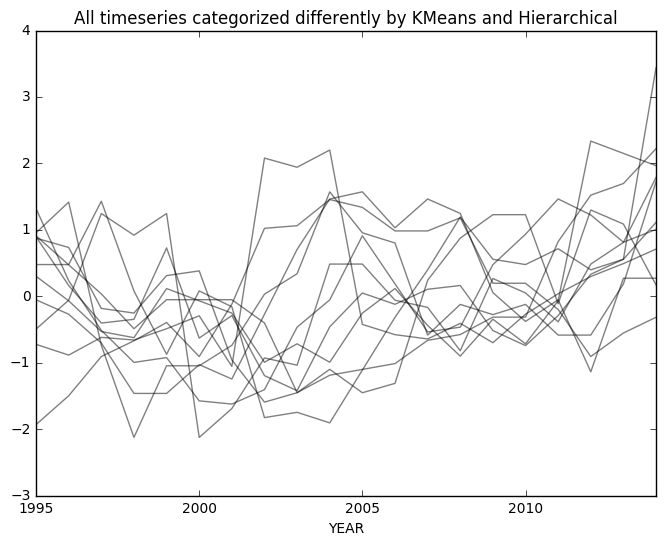

In [40]:
diff = df_NY_standardized[(df_NY_standardized['hierarchical2'] 
                           - df_NY_standardized['kmeans2']) != 1]
diff.iloc[:, 0:20].T.plot(legend=False, alpha=0.5, c='k',
                         title='All timeseries categorized differently by KMeans and Hierarchical',
                         figsize=(8,6))

**Picture 10: Structure of timeseries which both of method categorized them differently**

Apparently, these timeseries have somewhat arbitrary structure, that is why, both of the methods categorized them differently.